In [2]:
# Install RDKit. Takes 2-3 minutes
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit
!pip install git+https://github.com/samoturk/mol2vec;

--2020-05-01 04:57:10--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.201.79, 104.18.200.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.201.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh [following]
--2020-05-01 04:57:10--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>]  81.12M   146MB/s    in 0.6s    

2020-05-01 04:57:11 (146 MB/s) - ‘Miniconda3-latest-Linux

In [4]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
!pip install PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
download = drive.CreateFile({'id': '1vaIlu1uOPs5IE9K6HT__9LhATuZkJ9uL'})
download.GetContentFile('model_300dim.zip')
import zipfile
with zipfile.ZipFile("model_300dim.zip","r") as zip_ref:
    zip_ref.extractall()
#https://drive.google.com/open?id=1vaIlu1uOPs5IE9K6HT__9LhATuZkJ9uL

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
     |████████████████████████████████| 987 kB 4.9 MB/s 
     |████████████████████████████████| 58 kB 6.7 MB/s 
     |████████████████████████████████| 98 kB 8.3 MB/s 
     |████████████████████████████████| 269 kB 61.0 MB/s 
     |████████████████████████████████| 70 kB 9.1 MB/s 
     |████████████████████████████████| 95 kB 5.3 MB/s 
     |████████████████████████████████| 89 kB 10.0 MB/s 
     |████████████████████████████████| 77 kB 6.9 MB/s 
     |█████

Lets import the required libraries.The 2 most important libraries that we'll be using are RdKit for molecular transformations from the SMILES representation of the molecules and mol2vec which has pretrained molecular embeddings for the molecular representation obtained from SMILES.


In [0]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import rdMolDescriptors
import numpy as np
import pandas as pd
import io
from google.colab import files
from rdkit.Chem import PandasTools
from gensim.models import word2vec
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec

In [6]:
uploaded=files.upload()

Saving final_test_file.csv to final_test_file.csv
Saving sample_submission.csv to sample_submission.csv
Saving test.csv to test.csv
Saving train.csv to train.csv


In [0]:
#train_files=pd.read_csv(io.BytesIO(uploaded['train.csv']))
train_files=pd.read_csv('train.csv')
test_files=pd.read_csv('final_test_file.csv')

Separate the target(binding affinity to be predicted) and the other columns.


In [0]:
target=train_files['Binding Affinity']
train_files.drop(columns='Binding Affinity',inplace=True)

Convert all the  SMILES representation to its corresponding Molecular representations,using the MolFromSmiles function provided in Rdkit.Chem

In [0]:
train_files['mol']=train_files['SMILES sequence'].apply(lambda x: Chem.MolFromSmiles(x))
test_files['mol']=test_files['SMILES sequence'].apply(lambda x: Chem.MolFromSmiles(x))

Lets see how the molecules look after converting from the SMILES sequence.

,SMILES sequence,mol
0,CCNC(C)C(NC)c1ccccc1,
1,CONC(=O)c1cncnc1,
2,CCNC1CCCN(Cc2ccsc2)C1,
3,CC(NC(=O)CSCCN)c1ccccc1,
4,CCC(CS)CN(C)c1ccccc1,
...,...,...
8995,CC(O)CCNC(=O)CNCc1ccccc1,
8996,N#Cc1cccc(-c2cnsc2)n1,
8997,Cc1ccnc(NC(CN)C(C)C)c1,
8998,CC(=O)CCc1cncnc1,

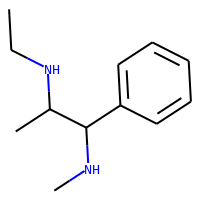
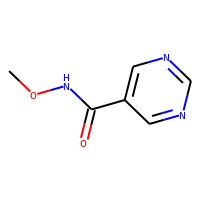
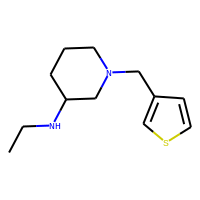
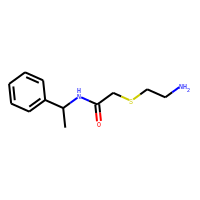
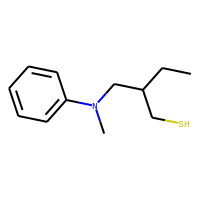
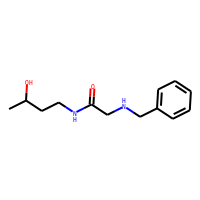
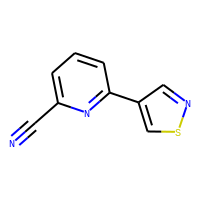
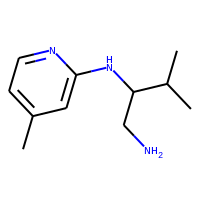
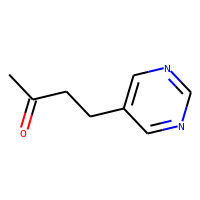
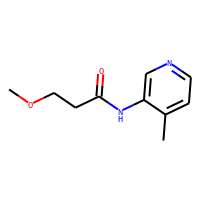

In [40]:
PandasTools.AddMoleculeColumnToFrame(train_files,'SMILES sequence','mol')
train_files

Load the pretrained/predefined molecular embeddings.These molecular embeddings are of 300 dimensions,i.e the increase the dimensionality of the data by 300 columns of numerical features of that molecule.

In [25]:
model = word2vec.Word2Vec.load('model_300dim.pkl')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Now we use the molecular embeddings to convert the molecules to molecular sentences.

In [0]:
train_files['sentence'] = train_files.apply(lambda x: MolSentence(mol2alt_sentence(x['mol'], 1)), axis=1)
test_files['sentence'] = test_files.apply(lambda x: MolSentence(mol2alt_sentence(x['mol'], 1)), axis=1)

In [45]:
train_files['sentence']

0       (2246728737, 3542456614, 2245384272, 773607102...
1       (2246728737, 3975275337, 864674487, 903112553,...
2       (2246728737, 3542456614, 2245384272, 773607102...
3       (2246728737, 3537119515, 2245273601, 146777865...
4       (2246728737, 3542456614, 2245384272, 150656359...
                              ...                        
8995    (2246728737, 3537119515, 2245273601, 161474856...
8996    (847433064, 2551483158, 2245900962, 551287920,...
8997    (2246728737, 422715066, 3217380708, 3207567135...
8998    (2246728737, 3545365497, 2246699815, 208074702...
8999    (2246728737, 3975275337, 864674487, 2222621677...
Name: sentence, Length: 9000, dtype: object

Now convert the molecular sentences to numerical vectors.

In [0]:
train_files['mol2vec'] = [DfVec(x) for x in sentences2vec(train_files['sentence'], model, unseen='UNK')]
test_files['mol2vec'] = [DfVec(x) for x in sentences2vec(test_files['sentence'], model, unseen='UNK')]

In [47]:
train_files['mol2vec']

0       (300,) dimensional vector
1       (300,) dimensional vector
2       (300,) dimensional vector
3       (300,) dimensional vector
4       (300,) dimensional vector
                  ...            
8995    (300,) dimensional vector
8996    (300,) dimensional vector
8997    (300,) dimensional vector
8998    (300,) dimensional vector
8999    (300,) dimensional vector
Name: mol2vec, Length: 9000, dtype: object

Now lets split the data into train and test set for using our regression model.

In [0]:
x_train = np.array([x.vec for x in train_files['mol2vec']])
y = target.values
x_test=np.array([x.vec for x in test_files['mol2vec']])
# from sklearn.model_selection import train_test_split
# x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)

In [29]:
x_train.shape

(9000, 300)

In [30]:
x_test.shape

(2500, 300)

Now I used Support Vector Regressor and validated using the following code for different values of C and epsilon.According to the documentation the C is Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive. The penalty is a squared l2 penalty,and epislon is Epsilon in the epsilon-SVR model. It specifies the epsilon-tube within which no penalty is associated in the training loss function with points predicted within a distance epsilon from the actual value.
The default kernel is rbf 

In [0]:
epsilon=[0.001,0.1,0.2,0.25,0.35,0.5,0.7,0.8]
C=[15,17,19,21,23,25,29,31,35,40,45,50,55,60,65,70]
for eps in epsilon:
  for c in C: 
    from sklearn.svm import SVR
    svr=SVR(C=c, epsilon=eps)
    svr.fit(x_train,y_train)
    sv_pred=svr.predict(x_test)
    from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
    print(f'c={c} epsilon={eps}')
    print('mean_squared_error',mean_squared_error(y_test,sv_pred)**0.5)
    print('mean_absolute_error',mean_absolute_error(y_test,sv_pred))
    print('r2_score',r2_score(y_test,sv_pred))
    print('====================================================================')

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVR
C=list(np.arange(50,110,3))
# print(C)
epsilon=list(np.arange(1.4,4.0,0.2))
# print(epsilon)
parameters = {'kernel':('linear', 'rbf','poly'), 'C':[55,50,65,70,90],'epsilon':[1.6,1.8,2.2,2.6,3.0]}
svr=SVR()
reg = GridSearchCV(svr, parameters,verbose=2)
reg.fit(x_train,y_train)
# from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
#     print(f'c={c} epsilon={eps}')
#     print('mean_squared_error',mean_squared_error(y_test,sv_pred)**0.5)
#     print('mean_absolute_error',mean_absolute_error(y_test,sv_pred))
#     print('r2_score',r2_score(y_test,sv_pred))
#     print('====================================================================')

Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV] C=55, epsilon=1.6, kernel=linear ................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................ C=55, epsilon=1.6, kernel=linear, total=128.7min
[CV] C=55, epsilon=1.6, kernel=linear ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 128.7min remaining:    0.0s


After  validation I concluded that it works fairly well for larger values of C i.e. we dont like make mistakes (allow a little bit of overfit) and a moderately high epsilon.

Lets see how the model performs.

In [0]:
from sklearn.svm import SVR
svr=SVR(C=80, epsilon=1.6)
svr.fit(x_train,y)
sv_pred=svr.predict(x_test)
# from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
# print('mean_squared_error',mean_squared_error(y_test,sv_pred)**0.5)
# print('mean_absolute_error',mean_absolute_error(y_test,sv_pred))
# print('r2_score',r2_score(y_test,sv_pred))

I also tried to use Ridge CV.It is basically Linear Regression with Ridge(L2) regularization with built in cross validation.


In [28]:
from sklearn.linear_model import RidgeCV
alphas = [0.1, 1, 10, 100, 1e3, 1e4, 2e4, 5e4, 8e4, 1e5, 1e6, 1e7, 1e8]
ridge = RidgeCV(alphas=alphas, store_cv_values=True)
ridge.fit(x_train, y_train)
cv_mse=np.mean(ridge.cv_values_,axis=0)
print("alphas: %s" % alphas)
print("CV MSE: %s" % cv_mse)
print("Best alpha using built-in RidgeCV: %f" % ridge.alpha_)

alphas: [0.1, 1, 10, 100, 1000.0, 10000.0, 20000.0, 50000.0, 80000.0, 100000.0, 1000000.0, 10000000.0, 100000000.0]
CV MSE: [ 5.97022334  5.97017729  5.96972769  5.96625161  5.98727579  6.49958644
  6.88243525  7.6940181   8.28964021  8.61550301 12.16908156 13.50881263
 13.71360173]
Best alpha using built-in RidgeCV: 100.000000


Best value of alpha came to be 100.

In [29]:
alpha=ridge.alpha_
print(alpha)

100.0


Now lets run and test our RidgeCV model for testing.

In [53]:
from sklearn import linear_model
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
ridge=linear_model.Ridge(alpha=100)
ridge.fit(x_train,y_train)
ridge_pred=ridge.predict(x_test)
print(mean_squared_error(y_test,ridge_pred)**0.5)
print(mean_absolute_error(y_test,ridge_pred))
print(r2_score(y_test,ridge_pred))

2.353900382140591
1.7045021825536093
0.6057187436756803


As compared to SVR it performs a little poor.

I also tried other regressors like GradientBoostingRegressor,RandomForest Regressor,KNN regressor.None of them outperformed the Support Vector Regressor.

Gradient Boosting Regressor

In [54]:
from sklearn.ensemble import GradientBoostingRegressor
gb_regr=GradientBoostingRegressor(n_estimators=250,max_depth=10)
gb_regr.fit(x_train,y_train)
gb_pred=gb_regr.predict(x_test)
print(mean_squared_error(y_test,gb_pred)**0.5)
print(mean_absolute_error(y_test,gb_pred))
print(r2_score(y_test,gb_pred))

2.550497565646151
1.8197599827076374
0.537107867299427


KNearestNeighbor regressor.

In [57]:
from sklearn.neighbors import KNeighborsRegressor
knn_regr=KNeighborsRegressor(n_neighbors=12)
knn_regr.fit(x_train,y_train) 
knn_pred=knn_regr.predict(x_test)
print(mean_squared_error(y_test,knn_pred))
print(mean_absolute_error(y_test,knn_pred))
print(r2_score(y_test,knn_pred))

7.434440157898934
2.0076499212962964
0.47097250641623933


Random Forest Regressor with number of estimators 250 and max depth 10.

In [58]:
from sklearn.ensemble import RandomForestRegressor
rf_regr=RandomForestRegressor(n_estimators=250,max_depth=10)
rf_regr.fit(x_train,y_train)
rf_pred=rf_regr.predict(x_test)
print(mean_squared_error(y_test,rf_pred)**0.5)
print(mean_absolute_error(y_test,rf_pred))
print(r2_score(y_test,rf_pred))

2.6295237594848584
1.9092440029793898
0.5079783970936878


Comparison with Neural Networks (from sklearn) with L-BFGS solver

In [63]:
from sklearn.neural_network import MLPRegressor
mlp_regr=MLPRegressor(solver='lbfgs',
                       alpha=1e-5,
                       hidden_layer_sizes=(150,60,35),
                       activation="relu",
                       max_iter=5000)
mlp_regr.fit(x_train,y_train)
mlp_pred=mlp_regr.predict(x_test)
print(mean_squared_error(y_test,mlp_pred)**0.5)
print(mean_absolute_error(y_test,mlp_pred))
print(r2_score(y_test,mlp_pred))

3.485922386260442
2.5421817198230423
0.13530011821604138


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLP Regressor with Adam Solver.

In [65]:
from sklearn.neural_network import MLPRegressor
mlp_regr=MLPRegressor(solver='adam',
                       hidden_layer_sizes=(250,125,25),
                       activation="relu",
                       max_iter=500)
mlp_regr.fit(x_train,y_train)
mlp_pred=mlp_regr.predict(x_test)
print(mean_squared_error(y_test,mlp_pred)**0.5)
print(mean_absolute_error(y_test,mlp_pred))
print(r2_score(y_test,mlp_pred))

2.6398812945526293
1.9391636710981925
0.5040946765806431


In [0]:
test_labels=pd.read_csv('final_test_file.csv')

In [39]:
test_labels['Binding Affinity']=sv_pred
test_labels

,SMILES sequence,Binding Affinity
0,CNC(=O)N(C)c1ncccn1,-21.901277
1,O=C(Cc1ccccc1)c1ccccn1,-19.464503
2,NC1C2CCSCC12,-20.800547
3,CCC(C)C(N)(CC)c1ccccc1,-16.093809
4,N#Cc1cccc(C2OCCC2=O)n1,-18.744401
...,...,...
2495,CC(N)C(C)Nc1ncccc1C#N,-25.389374
2496,CCCCOc1ccccc1C(=O)OC,-13.247166
2497,NN1CC2CCCC1C2,-20.444378
2498,CN1CCC(C(=O)O)c2ccccc21,-16.428815


In [0]:
test_labels.to_csv('final_submission2.csv', index = False)

In [36]:
sv_pred.shape

(2500,)